In [2]:
!pip install rogue

In [13]:
## for data
import pandas as pd
import numpy as np

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for analysis
import re
import nltk
import contractions

## for machine learning
from sklearn import preprocessing, model_selection, feature_extraction, feature_selection, metrics, manifold, naive_bayes, pipeline
from sklearn.model_selection import train_test_split

## for deep learning
from tensorflow.keras import callbacks, models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input,LSTM,Embedding,Dense,Concatenate,Attention
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

## for W2V and textRank
import gensim
import gensim.downloader as gensim_api

## for summarization
#import rouge
import difflib

## for time
import time

In [2]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
    print("Physical Devices : {}".format(tf.config.list_physical_devices()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0
Physical Devices : [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-03-31 16:52:17.821096: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-31 16:52:23.864034: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 30998 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:86:00.0, compute capability: 7.0
2023-03-31 16:52:23.898129: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 30998 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:86:00.0, compute capability: 7.0


<h2> Data Reading and Preprocessing </h2>

In [3]:
#FUNCTION TO CREATE STOP WORDS
def create_stopwords(lst_langs=["english"], lst_add_words=[], lst_keep_words=[]):
    lst_stopwords = set()
    for lang in lst_langs:
        lst_stopwords = lst_stopwords.union( set(nltk.corpus.stopwords.words(lang)) )
    lst_stopwords = lst_stopwords.union(lst_add_words)
    lst_stopwords = list(set(lst_stopwords) - set(lst_keep_words))
    return sorted(list(set(lst_stopwords)))

In [4]:
lst_stopwords = create_stopwords()
print(len(lst_stopwords))

179


In [5]:
df = pd.read_csv("Wikipedia-Level-4-Articles.csv")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df

,Title,Article,Category,Summary
0,Masaccio,"Masaccio (UK: , US: , Italian: [maˈzattʃo]; De...",People,"Masaccio (UK: , US: , Italian: [maˈzattʃo]; De..."
1,Hokusai,"Katsushika Hokusai (葛飾 北斎, c. 31 October 1760 ...",People,"Katsushika Hokusai (葛飾 北斎, c. 31 October 1760 ..."
2,Steven Spielberg,"Steven Allan Spielberg (; born December 18, 1...",People,"Steven Allan Spielberg (; born December 18, 1..."
3,Che Guevara,"Ernesto ""Che"" Guevara (Spanish: [ˈtʃe ɣeˈβaɾa]...",People,"Ernesto ""Che"" Guevara (Spanish: [ˈtʃe ɣeˈβaɾa]..."
4,Jöns Jacob Berzelius,Baron Jöns Jacob Berzelius (Swedish: [jœns ˈjɑ...,People,Baron Jöns Jacob Berzelius (Swedish: [jœns ˈjɑ...
...,...,...,...,...
10004,Zimbabwe,"Zimbabwe (), officially the Republic of Zimbab...",Geography,"Zimbabwe (), officially the Republic of Zimbab..."
10005,Nile,The Nile is a major north-flowing river in nor...,Geography,The Nile is a major north-flowing river in nor...
10006,Republic of Ireland,"Ireland (Irish: Éire [ˈeːɾʲə] (listen)), also ...",Geography,"Ireland (Irish: Éire [ˈeːɾʲə] (listen)), also ..."
10007,Lake Erie,"Lake Erie ( ""eerie"") is the fourth largest lak...",Geography,"Lake Erie ( ""eerie"") is the fourth largest lak..."


In [6]:
#FUNCTION TO CLEAN THE TEXT

def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True
    
def utils_preprocess_text(txt, lst_regex=None, punkt=True, lower=True, slang=True, lst_stopwords=None, stemm=False, lemm=True):
    ## Regex (in case, before cleaning)
    if lst_regex is not None: 
        for regex in lst_regex:
            txt = re.sub(regex, '', txt)

    ## Clean 
    ### separate sentences with '. '
    txt = re.sub(r'\.(?=[^ \W\d])', '. ', str(txt))
    ### remove punctuations and characters
    txt = re.sub(r'[^\w\s]', '', txt) if punkt is True else txt
    ### strip
    txt = " ".join([word.strip() for word in txt.split()])
    ### lowercase
    txt = txt.lower() if lower is True else txt
    ### slang
    txt = contractions.fix(txt) if slang is True else txt
            
    ## Tokenize (convert from string to list)
    lst_txt = txt.split()
                
    ## Stemming (remove -ing, -ly, ...)
    if stemm is True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_txt = [ps.stem(word) for word in lst_txt]
                
    ## Lemmatization (convert the word into root word)
    if lemm is True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_txt = [lem.lemmatize(word) for word in lst_txt]

    ## Stopwords
    if lst_stopwords is not None:
        lst_txt = [word for word in lst_txt if word not in lst_stopwords]
        
    lst_txt = [ word for word in lst_txt if isEnglish(word) is True]
    
    # remove words less than three letters
    lst_txt = [word for word in lst_txt if len(word) >= 3]
            
    ## Back to string
    txt = " ".join(lst_txt)
    return txt



#FUNCTION TO ADD A COLUMN CONTAINING THE CLEANED TEXT
def add_preprocessed_text(data, column, lst_regex=None, punkt=False, lower=False, slang=False, lst_stopwords=None, stemm=False, lemm=True, remove_na=True):
    dtf = data.copy()

    ## apply preprocess
    dtf = dtf[ pd.notnull(dtf[column]) ]
    dtf[column+"_clean"] = dtf[column].apply(lambda x: utils_preprocess_text(x, lst_regex, punkt, lower, slang, lst_stopwords, stemm, lemm))
    
    ## residuals
    dtf["check"] = dtf[column+"_clean"].apply(lambda x: len(x))
    if dtf["check"].min() == 0:
        print("--- found NAs ---")
        print(dtf[[column,column+"_clean"]][dtf["check"]==0].head())
        if remove_na is True:
            dtf = dtf[dtf["check"]>0] 
            
    return dtf.drop("check", axis=1)

In [7]:
print("Starting to clean the Articles")
start = time.time()
df_cleaned = add_preprocessed_text(df, column="Article", 
                            punkt=True, lower=True, slang=True, lst_stopwords=lst_stopwords, lemm=True,stemm=True)
end = time.time()
print("Time take to clean the Articles : {}".format(end-start))


Starting to clean the Articles
Time take to clean the Articles : 860.2032513618469


In [8]:
print("Starting to clean the Summary")
start = time.time()
df_cleaned = add_preprocessed_text(df_cleaned, column="Summary", 
                            punkt=True, lower=True, slang=True, lst_stopwords=lst_stopwords, lemm=True)
end = time.time()
print("Time take to clean the Summary : {}".format(end-start))


Starting to clean the Summary
Time take to clean the Summary : 12.686798572540283


In [9]:
df_cleaned

,Title,Article,Category,Summary,Article_clean,Summary_clean
0,Masaccio,"Masaccio (UK: , US: , Italian: [maˈzattʃo]; De...",People,"Masaccio (UK: , US: , Italian: [maˈzattʃo]; De...",masaccio italian decemb 1401 summer 1428 born ...,masaccio italian december 1401 summer 1428 bor...
1,Hokusai,"Katsushika Hokusai (葛飾 北斎, c. 31 October 1760 ...",People,"Katsushika Hokusai (葛飾 北斎, c. 31 October 1760 ...",katsushika hokusai octob 1760 may 1849 known s...,katsushika hokusai october 1760 may 1849 known...
2,Steven Spielberg,"Steven Allan Spielberg (; born December 18, 1...",People,"Steven Allan Spielberg (; born December 18, 1...",steven allan spielberg born decemb 1946 americ...,steven allan spielberg born december 1946 amer...
3,Che Guevara,"Ernesto ""Che"" Guevara (Spanish: [ˈtʃe ɣeˈβaɾa]...",People,"Ernesto ""Che"" Guevara (Spanish: [ˈtʃe ɣeˈβaɾa]...",ernesto che guevara spanish june 1928 octob 19...,ernesto che guevara spanish june 1928 october ...
4,Jöns Jacob Berzelius,Baron Jöns Jacob Berzelius (Swedish: [jœns ˈjɑ...,People,Baron Jöns Jacob Berzelius (Swedish: [jœns ˈjɑ...,baron jacob berzeliu swedish contemporari name...,baron jacob berzelius swedish contemporary nam...
...,...,...,...,...,...,...
10004,Zimbabwe,"Zimbabwe (), officially the Republic of Zimbab...",Geography,"Zimbabwe (), officially the Republic of Zimbab...",zimbabw offici republ zimbabw landlock countri...,zimbabwe officially republic zimbabwe landlock...
10005,Nile,The Nile is a major north-flowing river in nor...,Geography,The Nile is a major north-flowing river in nor...,nile major northflow river northeastern africa...,nile major northflowing river northeastern afr...
10006,Republic of Ireland,"Ireland (Irish: Éire [ˈeːɾʲə] (listen)), also ...",Geography,"Ireland (Irish: Éire [ˈeːɾʲə] (listen)), also ...",ireland irish listen also known republ ireland...,ireland irish listen also known republic irela...
10007,Lake Erie,"Lake Erie ( ""eerie"") is the fourth largest lak...",Geography,"Lake Erie ( ""eerie"") is the fourth largest lak...",lake eri eeri fourth largest lake surfac area ...,lake erie eerie fourth largest lake surface ar...


In [10]:
df_cleaned.to_csv("Wikipedia-Level-4-Articles-Cleaned-2.csv")

<h2>Cleaned DF</h2>

In [14]:
df_cleaned = pd.read_csv("Wikipedia-Level-4-Articles-Cleaned-1.csv")

# Define the categories you want to select
categories = ["People", "Arts", "History", "Biology_and_health_sciences", "Everyday_life", "Geography", "Philosophy_and_religion", "Society_and_social_sciences"]

# Create an empty list to store the selected rows
selected_rows = []

# Loop through each category and select 30 rows
for category in categories:
    category_rows = df_cleaned[df_cleaned["Category"] == category].head(200)
    selected_rows.append(category_rows)

# Concatenate all the selected rows into a new dataframe
df_cleaned = pd.concat(selected_rows)

In [15]:
df_cleaned

,Unnamed: 0,Title,Article,Category,Summary,Article_clean,Summary_clean
0,0,Masaccio,"Masaccio (UK: , US: , Italian: [maˈzattʃo]; De...",People,"Masaccio (UK: , US: , Italian: [maˈzattʃo]; De...",masaccio uk u italian december 21 1401 summer ...,masaccio uk u italian december 21 1401 summer ...
1,1,Hokusai,"Katsushika Hokusai (葛飾 北斎, c. 31 October 1760 ...",People,"Katsushika Hokusai (葛飾 北斎, c. 31 October 1760 ...",katsushika hokusai c 31 october 1760 10 may 18...,katsushika hokusai c 31 october 1760 10 may 18...
2,2,Steven Spielberg,"Steven Allan Spielberg (; born December 18, 1...",People,"Steven Allan Spielberg (; born December 18, 1...",steven allan spielberg born december 18 1946 a...,steven allan spielberg born december 18 1946 a...
3,3,Che Guevara,"Ernesto ""Che"" Guevara (Spanish: [ˈtʃe ɣeˈβaɾa]...",People,"Ernesto ""Che"" Guevara (Spanish: [ˈtʃe ɣeˈβaɾa]...",ernesto che guevara spanish 14 june 1928 9 oct...,ernesto che guevara spanish 14 june 1928 9 oct...
4,4,Jöns Jacob Berzelius,Baron Jöns Jacob Berzelius (Swedish: [jœns ˈjɑ...,People,Baron Jöns Jacob Berzelius (Swedish: [jœns ˈjɑ...,baron jacob berzelius swedish contemporary nam...,baron jacob berzelius swedish contemporary nam...
...,...,...,...,...,...,...,...
10004,10004,Zimbabwe,"Zimbabwe (), officially the Republic of Zimbab...",Geography,"Zimbabwe (), officially the Republic of Zimbab...",zimbabwe officially republic zimbabwe landlock...,zimbabwe officially republic zimbabwe landlock...
10005,10005,Nile,The Nile is a major north-flowing river in nor...,Geography,The Nile is a major north-flowing river in nor...,nile major northflowing river northeastern afr...,nile major northflowing river northeastern afr...
10006,10006,Republic of Ireland,"Ireland (Irish: Éire [ˈeːɾʲə] (listen)), also ...",Geography,"Ireland (Irish: Éire [ˈeːɾʲə] (listen)), also ...",ireland irish listen also known republic irela...,ireland irish listen also known republic irela...
10007,10007,Lake Erie,"Lake Erie ( ""eerie"") is the fourth largest lak...",Geography,"Lake Erie ( ""eerie"") is the fourth largest lak...",lake erie eerie fourth largest lake surface ar...,lake erie eerie fourth largest lake surface ar...


<h2> Exploratory Data Analysis </h2>

In [16]:
#FUNCTION TO CREATE THE WORD FREQUENCIES
def word_freq(corpus, ngrams=[1,2,3], top=10, figsize=(10,7)):
    lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
    ngrams = [ngrams] if type(ngrams) is int else ngrams
    
    ## calculate
    dtf_freq = pd.DataFrame()
    for n in ngrams:
        dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, n))
        dtf_n = pd.DataFrame(dic_words_freq.most_common(), columns=["word","freq"])
        dtf_n["ngrams"] = n
        dtf_freq = dtf_freq.append(dtf_n)
    dtf_freq["word"] = dtf_freq["word"].apply(lambda x: " ".join(string for string in x) )
    dtf_freq = dtf_freq.sort_values(["ngrams","freq"], ascending=[True,False])
    
    ## plot
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(x="freq", y="word", hue="ngrams", dodge=False, ax=ax,
                data=dtf_freq.groupby('ngrams')["ngrams","freq","word"].head(top))
    ax.set(xlabel=None, ylabel=None, title="Most frequent words")
    ax.grid(axis="x")
    plt.show()
    return dtf_freq

Finding out the most frequent words in Articles


IOStream.flush timed out


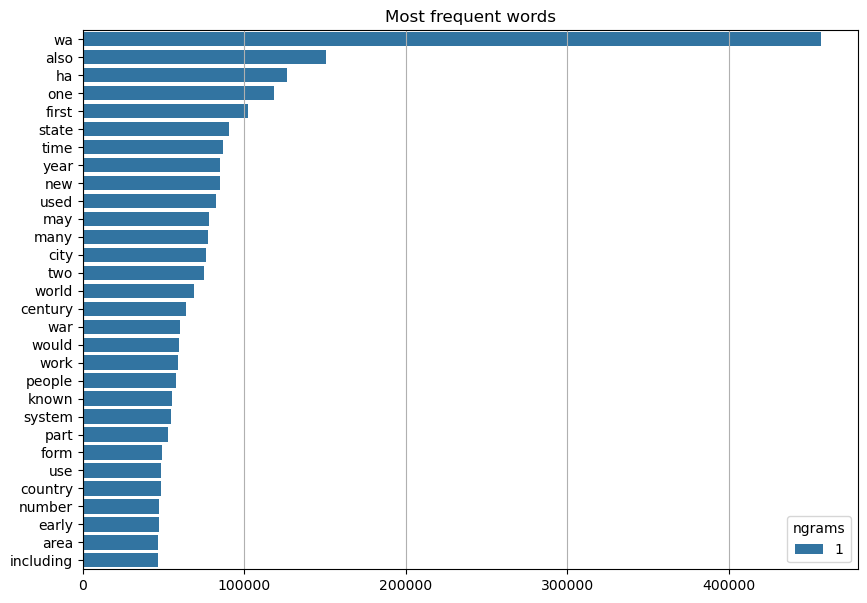

Time taken to find most frequent words in Articles : 120.40030884742737


In [17]:
print("Finding out the most frequent words in Articles")
start = time.time()
df_frequency = word_freq(corpus=df_cleaned["Article_clean"], ngrams=[1], top=30, figsize=(10,7))
end = time.time()
print("Time taken to find most frequent words in Articles : {}".format(end-start))

In [18]:
thres = 20
X_top_words = len(df_frequency[df_frequency["freq"]>thres])
X_top_words

58390

Finding out the most frequent words in Summaries


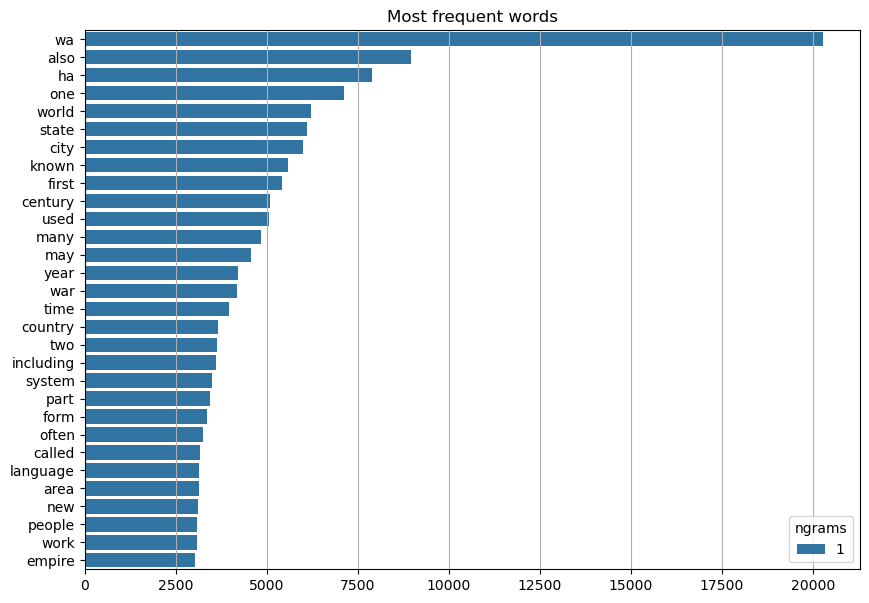

Time taken to find most frequent words in Summaries : 7.987321615219116


In [19]:
print("Finding out the most frequent words in Summaries")
start = time.time()
df_frequency = word_freq(corpus=df_cleaned["Summary_clean"], ngrams=[1], top=30, figsize=(10,7))
end = time.time()
print("Time taken to find most frequent words in Summaries : {}".format(end-start))

In [20]:
thres = 20
Y_top_words = len(df_frequency[df_frequency["freq"]>thres])
Y_top_words

9494

In [21]:
#FUNCTION TO FIND THE STATISTICS ABOUT THE SENTENCE LENGTH
def add_text_length(data, column):
    dtf = data.copy()
    dtf['word_count'] = dtf[column].apply(lambda x: len(nltk.word_tokenize(str(x))) )
    dtf['char_count'] = dtf[column].apply(lambda x: sum(len(word) for word in nltk.word_tokenize(str(x))) )
    dtf['sentence_count'] = dtf[column].apply(lambda x: len(nltk.sent_tokenize(str(x))) )
    dtf['avg_word_length'] = dtf['char_count'] / dtf['word_count']
    dtf['avg_sentence_lenght'] = dtf['word_count'] / dtf['sentence_count']
    print(dtf[['char_count','word_count','sentence_count','avg_word_length','avg_sentence_lenght']].describe().T[["min","mean","max"]])
    return dtf

In [22]:
X = add_text_length(df_cleaned, "Article_clean")

                           min          mean            max
char_count           507.00000  22530.357478  147579.000000
word_count            61.00000   3487.168548   22149.000000
sentence_count         1.00000      1.000000       1.000000
avg_word_length        4.75629      6.465148       8.713689
avg_sentence_lenght   61.00000   3487.168548   22149.000000


In [23]:
Y = add_text_length(df_cleaned, "Summary_clean")

                           min         mean          max
char_count           43.000000  1127.172445  7561.000000
word_count            9.000000   171.217105  1183.000000
sentence_count        1.000000     1.000000     1.000000
avg_word_length       4.611111     6.592787     9.322581
avg_sentence_lenght   9.000000   171.217105  1183.000000


In [24]:
def plot_distributions(dtf, x, max_cat=20, top=None, y=None, bins=None, figsize=(10,5)):
    ## univariate
    if y is None:
        fig, ax = plt.subplots(figsize=figsize)
        fig.suptitle(x, fontsize=15)
        ### categorical
        if dtf[x].nunique() <= max_cat:
            if top is None:
                dtf[x].reset_index().groupby(x).count().sort_values(by="index").plot(kind="barh", legend=False, ax=ax).grid(axis='x')
            else:   
                dtf[x].reset_index().groupby(x).count().sort_values(by="index").tail(top).plot(kind="barh", legend=False, ax=ax).grid(axis='x')
            ax.set(ylabel=None)
        ### numerical
        else:
            sns.distplot(dtf[x], hist=True, kde=True, kde_kws={"shade":True}, ax=ax)
            ax.grid(True)
            ax.set(xlabel=None, yticklabels=[], yticks=[])

    ## bivariate
    else:
        fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=figsize)
        fig.suptitle(x, fontsize=15)
        for i in dtf[y].unique():
            sns.distplot(dtf[dtf[y]==i][x], hist=True, kde=False, bins=bins, hist_kws={"alpha":0.8}, axlabel="", ax=ax[0])
            sns.distplot(dtf[dtf[y]==i][x], hist=False, kde=True, kde_kws={"shade":True}, axlabel="", ax=ax[1])
        ax[0].set(title="histogram")
        ax[0].grid(True)
        ax[0].legend(dtf[y].unique())
        ax[1].set(title="density")
        ax[1].grid(True)
    plt.show()

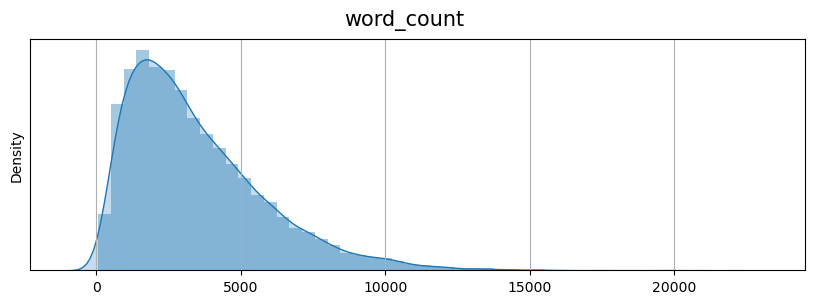

In [25]:
plot_distributions(X, x="word_count", figsize=(10,3))

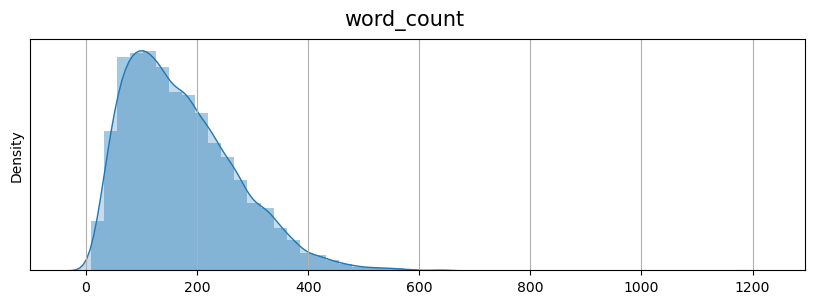

In [26]:
plot_distributions(Y, x="word_count", figsize=(10,3))

<h2> Preprocessing (Train-Test Split) </h2>

In [27]:
x_train, x_test, y_train, y_test = train_test_split( df_cleaned["Article_clean"], df_cleaned["Summary_clean"], test_size = 0.2 , random_state = 42)
x_train = pd.DataFrame(x_train, columns = ["Article_clean"])
x_test = pd.DataFrame(x_test, columns = ["Article_clean"])
y_train = pd.DataFrame(y_train, columns = ["Summary_clean"])
y_test = pd.DataFrame(y_test, columns = ["Summary_clean"])

In [28]:
len(x_train.iloc[0]["Article_clean"])

7846

In [29]:
len(y_train.iloc[0]["Summary_clean"])

371

In [30]:
#FUNCTION TO CREATE NGRAMS
def utils_preprocess_ngrams(corpus, ngrams=1, grams_join=" ", lst_ngrams_detectors=[]):
    ## create list of n-grams
    lst_corpus = []
    for string in corpus:
        lst_words = string.split()
        lst_grams = [grams_join.join(lst_words[i:i + ngrams]) for i in range(0, len(lst_words), ngrams)]
        lst_corpus.append(lst_grams)
    
    ## detect common bi-grams and tri-grams
    if len(lst_ngrams_detectors) != 0:
        for detector in lst_ngrams_detectors:
            lst_corpus = list(detector[lst_corpus])
    return lst_corpus


In [31]:
#FUNCTION TO CREATE TOKENIZED TEXT WITH SAME PADDING
def text2seq(corpus, ngrams=1, grams_join=" ", lst_ngrams_detectors=[], fitted_tokenizer=None, top=None, oov=None, maxlen=None, padding="<PAD>"):    
    print("--- tokenization ---")
    
    ## detect common n-grams in corpus
    lst_corpus = utils_preprocess_ngrams(corpus, ngrams=ngrams, grams_join=grams_join, lst_ngrams_detectors=lst_ngrams_detectors)

    ## bow with keras to get text2tokens without creating the sparse matrix
    ### train
    if fitted_tokenizer is None:
        tokenizer = kprocessing.text.Tokenizer(num_words=top, lower=False, split=' ', char_level=False, oov_token=oov,
                                               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
        tokenizer.fit_on_texts(lst_corpus)
        dic_vocabulary = {padding:0}
        words = tokenizer.word_index if top is None else dict(list(tokenizer.word_index.items())[0:top+1])
        dic_vocabulary.update(words)
        print(len(dic_vocabulary), "words")
    else:
        tokenizer = fitted_tokenizer
    ### transform
    lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

    ## padding sequence (from [1,2],[3,4,5,6] to [0,0,1,2],[3,4,5,6])
    print("--- padding to sequence ---")
    X = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=maxlen, padding="post", truncating="post")
    print(X.shape[0], "sequences of length", X.shape[1]) 

    ## plot heatmap
    fig, ax = plt.subplots(figsize=(15,5))
    sns.heatmap(X==0, vmin=0, vmax=1, cbar=False, ax=ax).set_title('Sequences Overview')
    plt.show()
    return {"X":X, "tokenizer":tokenizer, "dic_vocabulary":dic_vocabulary} if fitted_tokenizer is None else X


<h3> Creating the paddings for Cleaned Articles </h3>

In [32]:
X_len = 6800
Y_len = 350

--- tokenization ---
58392 words
--- padding to sequence ---
8007 sequences of length 6800


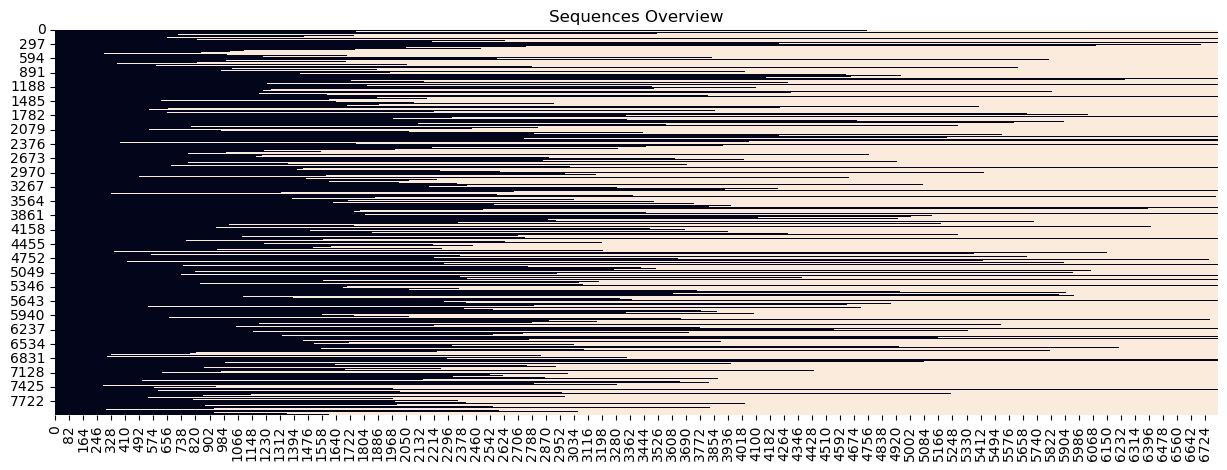

In [33]:
dic_seq = text2seq(corpus=x_train["Article_clean"], top=X_top_words, maxlen=X_len)

In [34]:
X_train = dic_seq["X"] 
X_tokenizer = dic_seq["tokenizer"] 
X_dic_vocabulary = dic_seq["dic_vocabulary"]

--- tokenization ---
--- padding to sequence ---
2002 sequences of length 6800


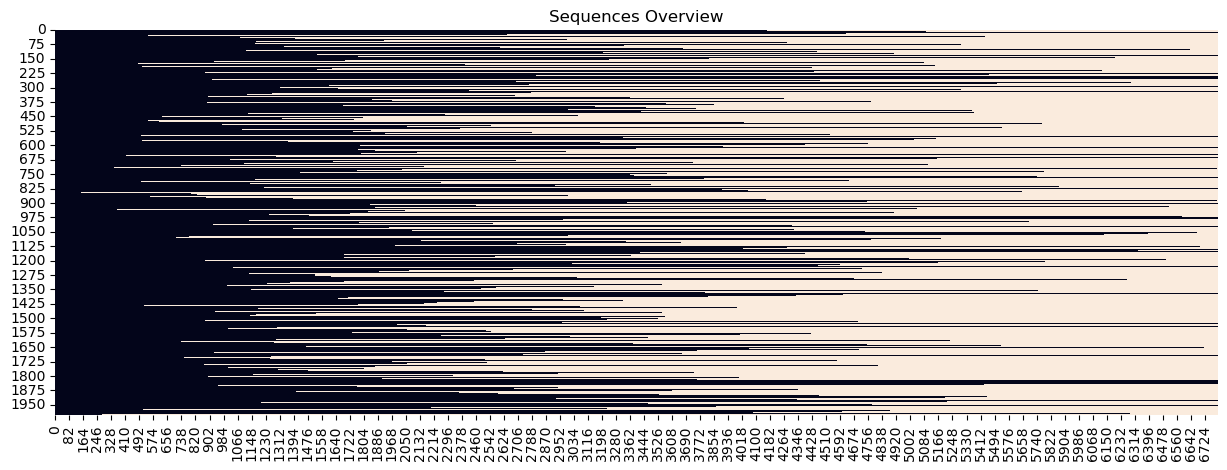

In [35]:
X_test = text2seq(corpus=x_test["Article_clean"], fitted_tokenizer=X_tokenizer, maxlen=X_train.shape[1])

<h3> Creating the paddings for Cleaned Summaries </h3>

In [36]:
y_train["Summary_clean"] = y_train["Summary_clean"].astype('str') 
y_test["Summary_clean"] = y_test["Summary_clean"].astype('str') 

In [37]:
print(y_train["Summary_clean"].isna().any())
print(y_test["Summary_clean"].isna().any())

False
False


In [38]:
y_train.dtypes

Summary_clean    object
dtype: object

In [39]:
y_test.dtypes

Summary_clean    object
dtype: object

In [40]:
y_train.iloc[0]["Summary_clean"]

'fiber fibre latin fibra natural artificial substance significantly longer wide fiber often used manufacture material strongest engineering material often incorporate fiber example carbon fiber ultrahighmolecularweight polyethylene synthetic fiber often produced cheaply large amount compared natural fiber clothing natural fiber give benefit comfort synthetic counterpart'

In [41]:
special_tokens = ("<START>", "<END>")
y_train["Summary_clean"] = y_train['Summary_clean'].apply(lambda x: special_tokens[0]+' '+x+' '+special_tokens[1])
y_test["Summary_clean"] = y_test['Summary_clean'].apply(lambda x: special_tokens[0]+' '+x+' '+special_tokens[1])


--- tokenization ---
9496 words
--- padding to sequence ---
8007 sequences of length 350


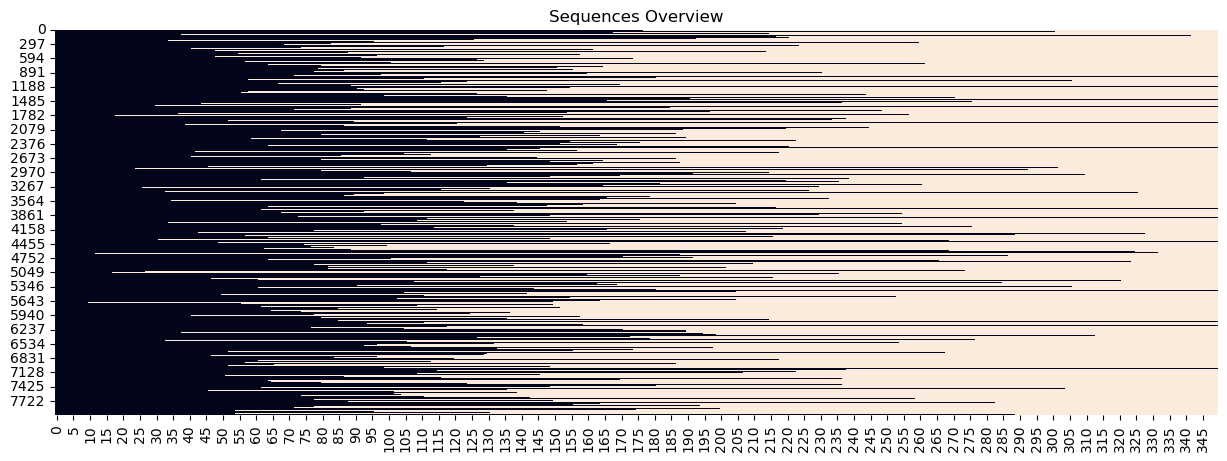

In [42]:
dic_seq = text2seq(corpus=y_train["Summary_clean"], top=Y_top_words, maxlen=Y_len)

In [43]:
Y_train = dic_seq["X"] 
Y_tokenizer = dic_seq["tokenizer"] 
Y_dic_vocabulary = dic_seq["dic_vocabulary"]

--- tokenization ---
--- padding to sequence ---
2002 sequences of length 350


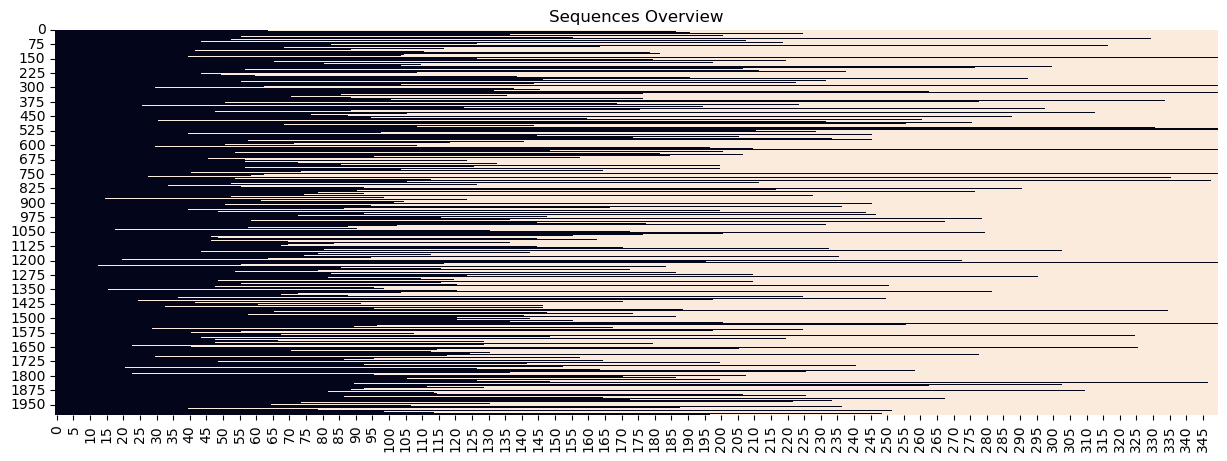

In [44]:
Y_test = text2seq(corpus=y_test["Summary_clean"], fitted_tokenizer=Y_tokenizer, maxlen=Y_train.shape[1])

<h2> Creating Word Embeddings(GloVe) using GENSIM </h2>

In [45]:
import gensim.downloader as api

In [46]:
nlp = api.load('glove-wiki-gigaword-300')

In [47]:
#FUNCTION TO MAP THE WORDS IN THE VOCABULARY TO THEIR RESPECTIVE WORD EMBEDDINGS
def vocabulary_embeddings(dic_vocabulary, nlp=None):
    nlp = gensim_api.load("glove-wiki-gigaword-300") if nlp is None else nlp
    embeddings = np.zeros((len(dic_vocabulary)+1, nlp.vector_size))
    for word,idx in dic_vocabulary.items():
        ## update the row with vector
        try:
            embeddings[idx] =  nlp[word]
        ## if word not in model then skip and the row stays all zeros
        except:
            pass
    print("vocabulary mapped to", embeddings.shape[0], "vectors of size", embeddings.shape[1])
    return embeddings

In [48]:
X_embeddings = vocabulary_embeddings(X_dic_vocabulary, nlp)
X_embeddings.shape

vocabulary mapped to 58393 vectors of size 300


(58393, 300)

In [49]:
Y_embeddings = vocabulary_embeddings(Y_dic_vocabulary, nlp)
Y_embeddings.shape

vocabulary mapped to 9497 vectors of size 300


(9497, 300)